# Лабораторная работа №2

In [168]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
import numpy as np 
import plotly.graph_objs as go
import plotly as py

## 1. Обработка датасета

1. **Добавим новый атрибут в датасет -   <font color='red'>Monthly salary</font>. Для этого разделим годовой доход на количество месяцев в году.**
2. **Уберём лишние нули в атрибуте <font color='red'>Annual Income</font> для более удобного представления данных на графиках.**
3. **Пропущенные значения в атрибуте <font color='red'>Profession</font> заменим на безработный(Unemployed).**
4. **Так же для более удобной визуализации кластеров возьмём только первые 400 строк из датасета.**

In [169]:

with open("Customers1.csv", encoding='utf-8') as r_file:  # Создаем объект reader, указываем символ-разделитель ","
    file_reader = csv.reader(r_file, delimiter=",")
    count = 0
    data = []
    for row in file_reader: # чтение csv  файла
        if count == 400:
            break
        if count != 0:
            Resousre2 = int(row[3])/ 1000 # Сокращение значений до тысяч
            
            Resousre = round(Resousre2 / 12,2) # вычисление месячной зарплаты 
            
            if row[1] == "0": # Замена значений ( 0 и 1 ) на Male и Female
                Resousre3 = "Male"
            else:
                Resousre3 = "Female"
                
            if row[5] == "": # Обработка пропусков в атрибуте "Profession"
                Resousre4 = "Unemployed"
            else:
                Resousre4 = row[5]
                
            data = data + [(row[0], Resousre3, row[2], str(Resousre2), row[4], Resousre4, row[6], row[7], str(Resousre))] # Формирование кортежа данных
        count += 1
        
    print(f'Всего в файле {count} строк.')
    with open("Customers2.csv", mode="w", encoding='utf-8') as w_file: # Создаём новый csv файлл
        file_writer = csv.writer(w_file, delimiter=",", lineterminator="\r")
        file_writer.writerow( 
            ["CustomerID", "Gender", "Age", "Annual Income(K$)", "Spending Score", "Profession", "Work Experience", # записываем заголовки
             "Family Size", "Monthly salary"])
        file_writer.writerows(data) # записываем данные 
    


Всего в файле 400 строк.


### <font color='Blue'>Отсортируем датасет для исключения еденичных выбросов значений</font>

In [170]:
shop = pd.read_csv('Customers2.csv') 

shop = shop[(shop.Age > 10) & (shop.Age < 71)] # Ограничим возраст от 10 до 70 лет, что бы исключить единичные выбросы значений.
shop = shop[shop['Annual Income(K$)'] < 100] # Ограничим годовой доход до 99 тыс, что бы исключить выбросы.

shop.head() # Вывод первых 5 строк

,CustomerID,Gender,Age,Annual Income(K$),Spending Score,Profession,Work Experience,Family Size,Monthly salary
0,1,Male,19,15.0,39,Healthcare,1,4,1.25
1,2,Male,21,35.0,81,Engineer,3,3,2.92
2,3,Female,20,86.0,6,Engineer,1,1,7.17
3,4,Female,23,59.0,77,Lawyer,0,2,4.92
4,5,Female,31,38.0,40,Entertainment,2,6,3.17


### <font color='Blue'>Типы данных в атирбутах датасета</font>

**Атрибуты с текстовым типом данных (<font color='red'>object</font>) - служат для подписи данных, что бы разделить их на группы.**

In [171]:
shop.dtypes

CustomerID             int64
Gender                object
Age                    int64
Annual Income(K$)    float64
Spending Score         int64
Profession            object
Work Experience        int64
Family Size            int64
Monthly salary       float64
dtype: object

### <font color='Blue'>Пропуски значений во всех атрибутах</font>

**Пропуски значений были только в атрибуте <font color='red'>Profession</font>. После преобразований выше все пропуски были обработанны**

In [172]:
shop.isnull().sum()

CustomerID           0
Gender               0
Age                  0
Annual Income(K$)    0
Spending Score       0
Profession           0
Work Experience      0
Family Size          0
Monthly salary       0
dtype: int64

### <font color='Blue'>Оисательная статистика</font>

**Атрибуты <font color='red'>CustomerID</font>, <font color='red'>Work Experience</font>, <font color='red'>Family Size</font> исключим из анализа.**

**<font color='red'>CustomerID</font> - порядковый номер покупателя, не несёт полезной информации.**

**<font color='red'>Work Experience</font>, <font color='red'>Family Size</font>  - не имеют выраженной корреляции ( из лр №1).**

**<font color='red'>Monthly salary</font> - является аналогом атрибута  <font color='red'>Annual Income(K$)</font>.**

In [173]:
shop.describe()

,CustomerID,Age,Annual Income(K$),Spending Score,Work Experience,Family Size,Monthly salary
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,149.293478,38.996377,54.681076,49.402174,3.413043,2.923913,4.556848
std,96.413413,14.804053,28.975434,26.575748,3.582235,1.567166,2.414779
min,1.000000,11.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,69.750000,28.000000,31.750000,28.000000,1.000000,2.000000,2.647500
50%,139.500000,36.500000,58.000000,50.000000,1.000000,3.000000,4.830000
75%,210.250000,49.000000,80.000000,73.000000,6.000000,4.000000,6.670000
max,390.000000,70.000000,99.000000,99.000000,15.000000,9.000000,8.250000


### <font color='Blue'>Гистограммы распределения значений:</font>

**Если сравнить гистрограммы атрибутов <font color='red'>Annual Income(K$)</font> и <font color='red'>Monthly salary</font> видно что столбцы распределения значений идентичны.**

In [174]:
plt.style.use('fivethirtyeight')

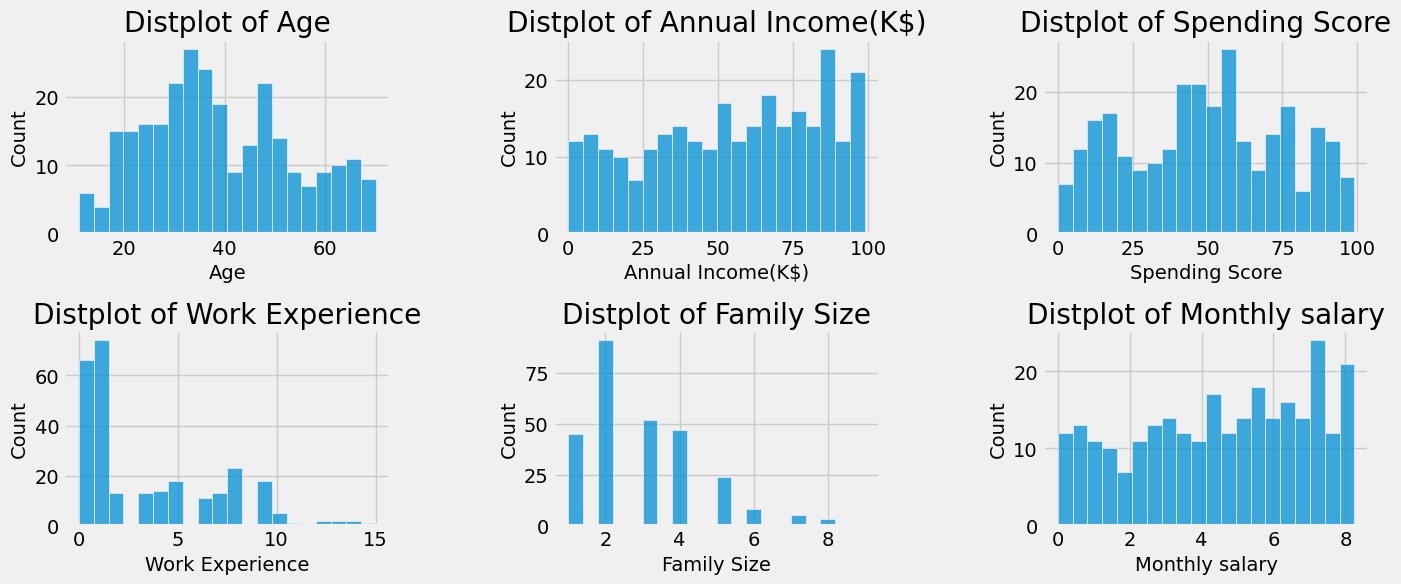

In [175]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income(K$)' , 'Spending Score', 'Work Experience', 'Family Size', 'Monthly salary']:
    n += 1
    plt.subplot(2 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.histplot(shop[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

# 2. Визуализация датасета

### <font color='Blue'>Матрица граффиков рассеивания атрибутов: <font color='red'>Age</font> , <font color='red'>Annual Income(K$)</font> , <font color='red'>Spending Score</font></font> 

**На графиках видно, что значения отношений атрибутов собираются в слабовыраженные группы** 

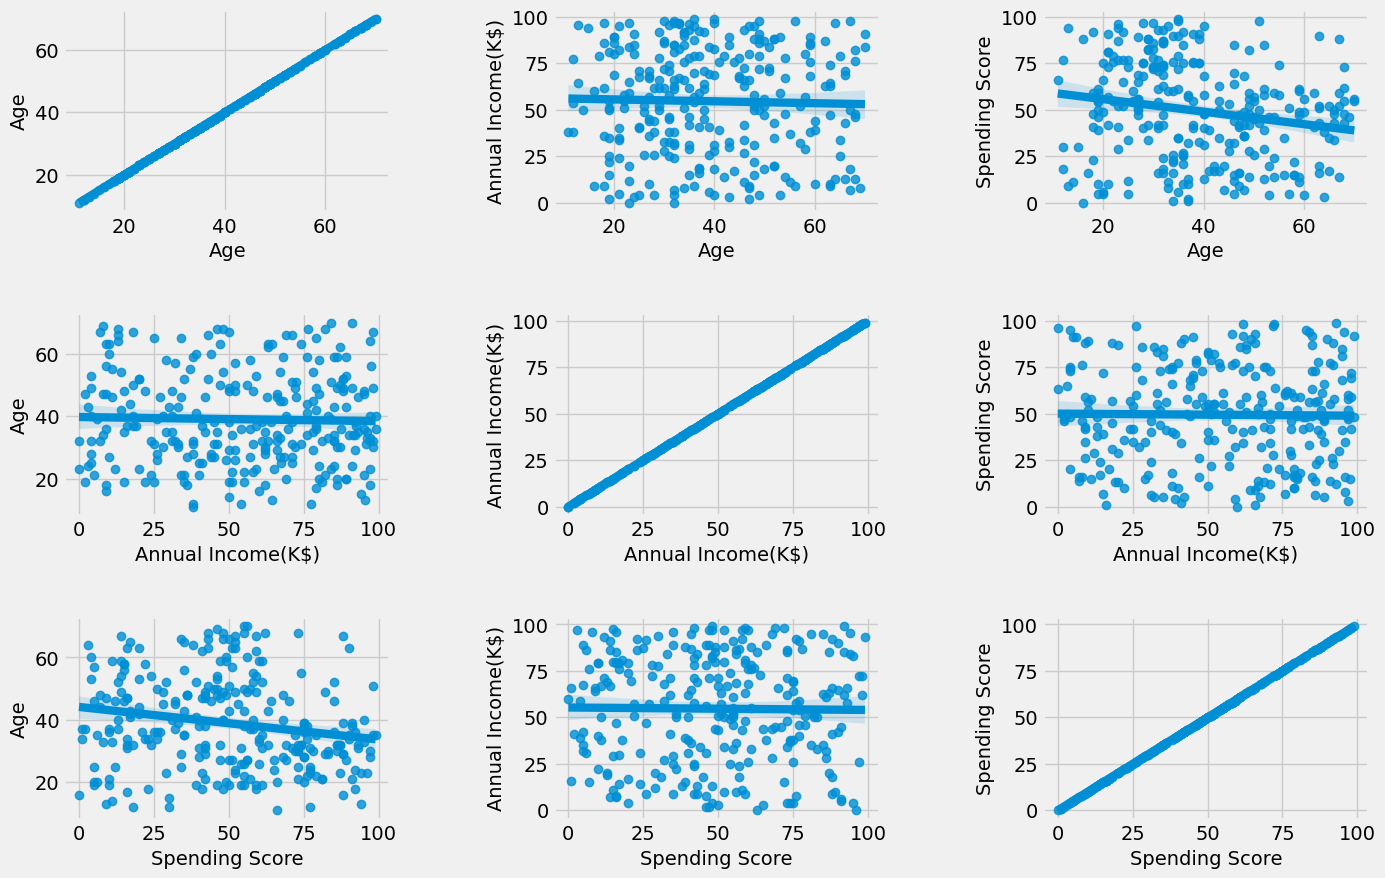

In [176]:
plt.figure(1 , figsize = (15 , 10))
n = 0 
for x in ['Age' , 'Annual Income(K$)' , 'Spending Score']:
    for y in ['Age' , 'Annual Income(K$)' , 'Spending Score']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = shop)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

### <font color='Blue'>График рассеивания атрибутов <font color='red'>Age</font> и <font color='red'>Annual Income(K$) </font> относительно <font color='red'> Gender</font></font>

**Смотря на графиик, можно выделить примероно 5 - кластеров**
1. Возростная группа от 18 до 40 с доходом от 0 до 40 тыс.
2. Возростная группа от 40 до 70 с доходом от 0 до 40 тыс.
3. Возростная группа от 18 до 40 с доходом от 40 до 70 тыс.
4. Возростная группа от 40 до 70 с доходом от 40 до 70 тыс.
5. Возростная группа от 18 до 70 с доходом больше 70 тыс.

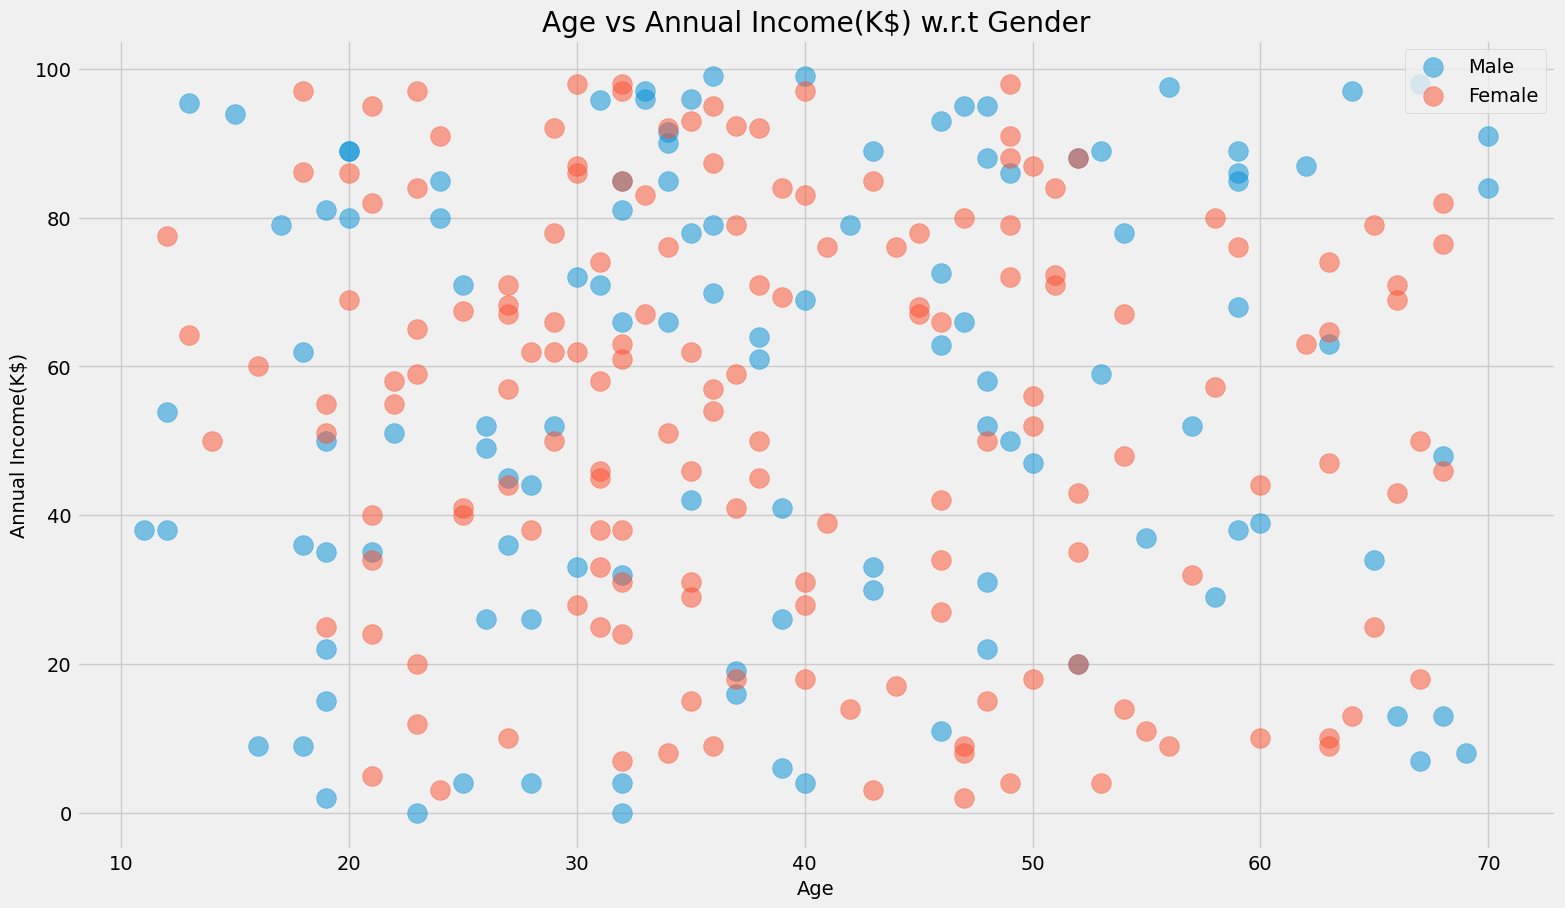

In [177]:
plt.figure(1 , figsize = (17 , 10))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income(K$)' , data = shop[(shop['Gender'] == gender)] ,
                s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Age'), plt.ylabel('Annual Income(K$)') 
plt.title('Age vs Annual Income(K$) w.r.t Gender')
plt.legend(loc='upper right')
plt.show()

### <font color='Blue'>График рассеивания атрибутов <font color='red'>Age</font> и <font color='red'>Annual Income(K$) </font> относительно <font color='red'> Profession </font></font>

**На графике видно, что доминирующая профессия Артист**

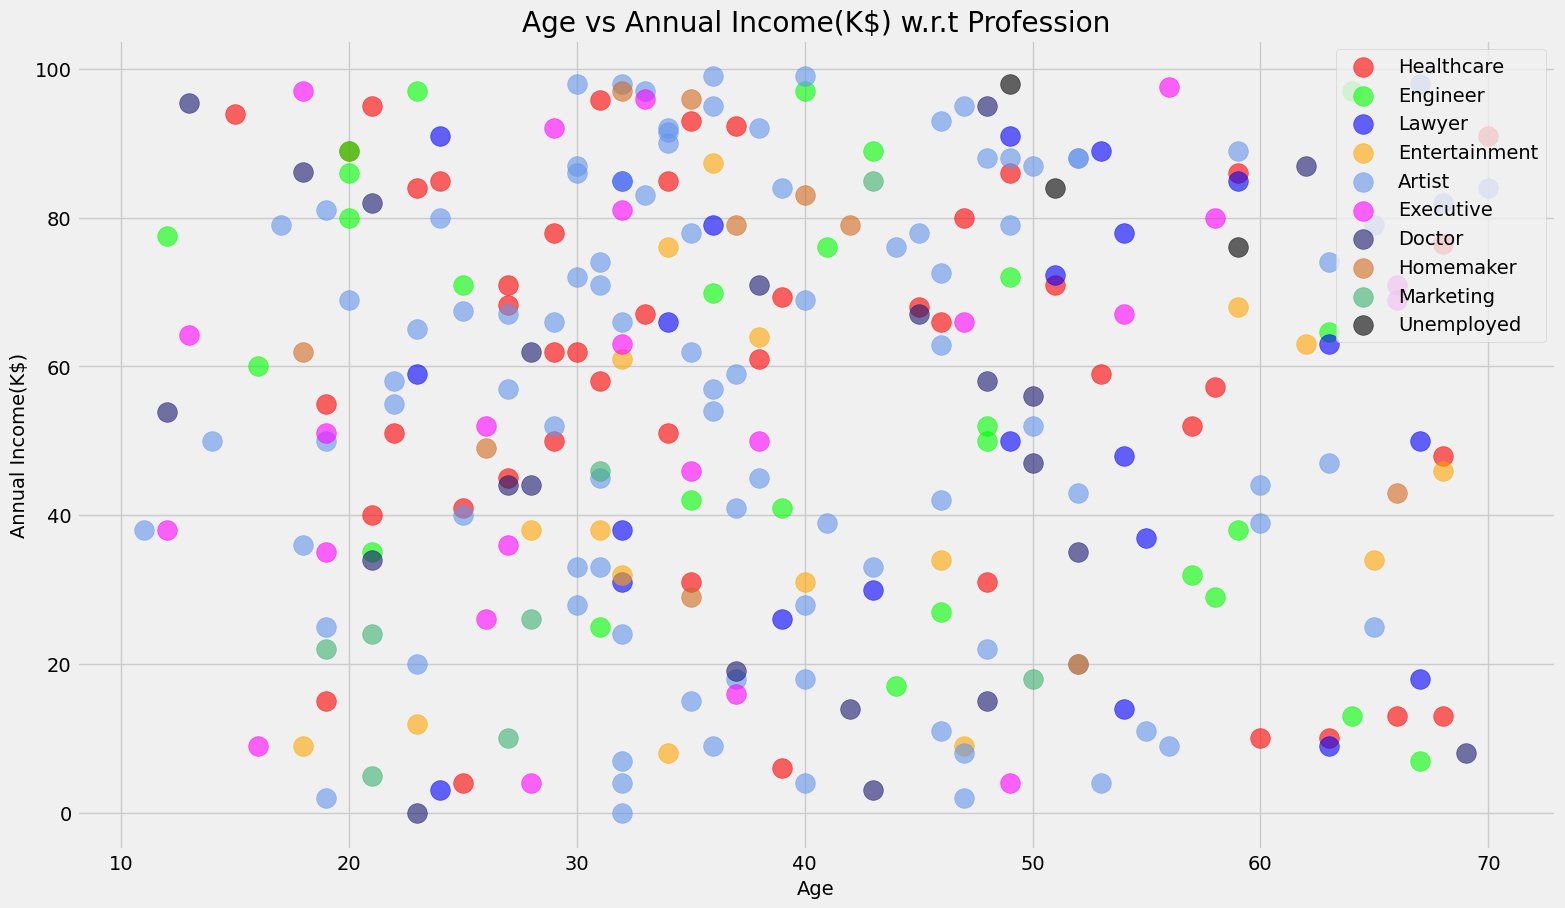

In [178]:
plt.figure(1 , figsize = (17 , 10))
row=['#FF0000', '#00FF00', '#0000FF', '#FFA500', '#6495ED', '#FF00FF', '#191970', '#D2691E','#3CB371','#000000']
i=0
for profession in ['Healthcare' , 'Engineer', 'Lawyer', 'Entertainment','Artist', 'Executive', 'Doctor', 'Homemaker','Marketing', 'Unemployed']:
    plt.scatter(x = 'Age' , y = 'Annual Income(K$)' , data = shop[(shop['Profession'] == profession) ] ,
                s = 200 , alpha = 0.6 , label = profession, c=row[i])
    i+=1
plt.xlabel('Age'), plt.ylabel('Annual Income(K$)') 
plt.title('Age vs Annual Income(K$) w.r.t Profession')
plt.legend(loc='upper right')
plt.show()

### <font color='Blue'>График рассеивания атрибутов <font color='red'>Age</font> и <font color='red'>Spending Score </font> относительно <font color='red'> Gender</font></font>

**Смотря на графиик, можно выделить примероно 5 - кластеров**

Как и в предыдущем случае. Группы будут делится по возрасту (молодые и пожилые). И по значению оценки количества покупок (низкая, средняя, высокая). 

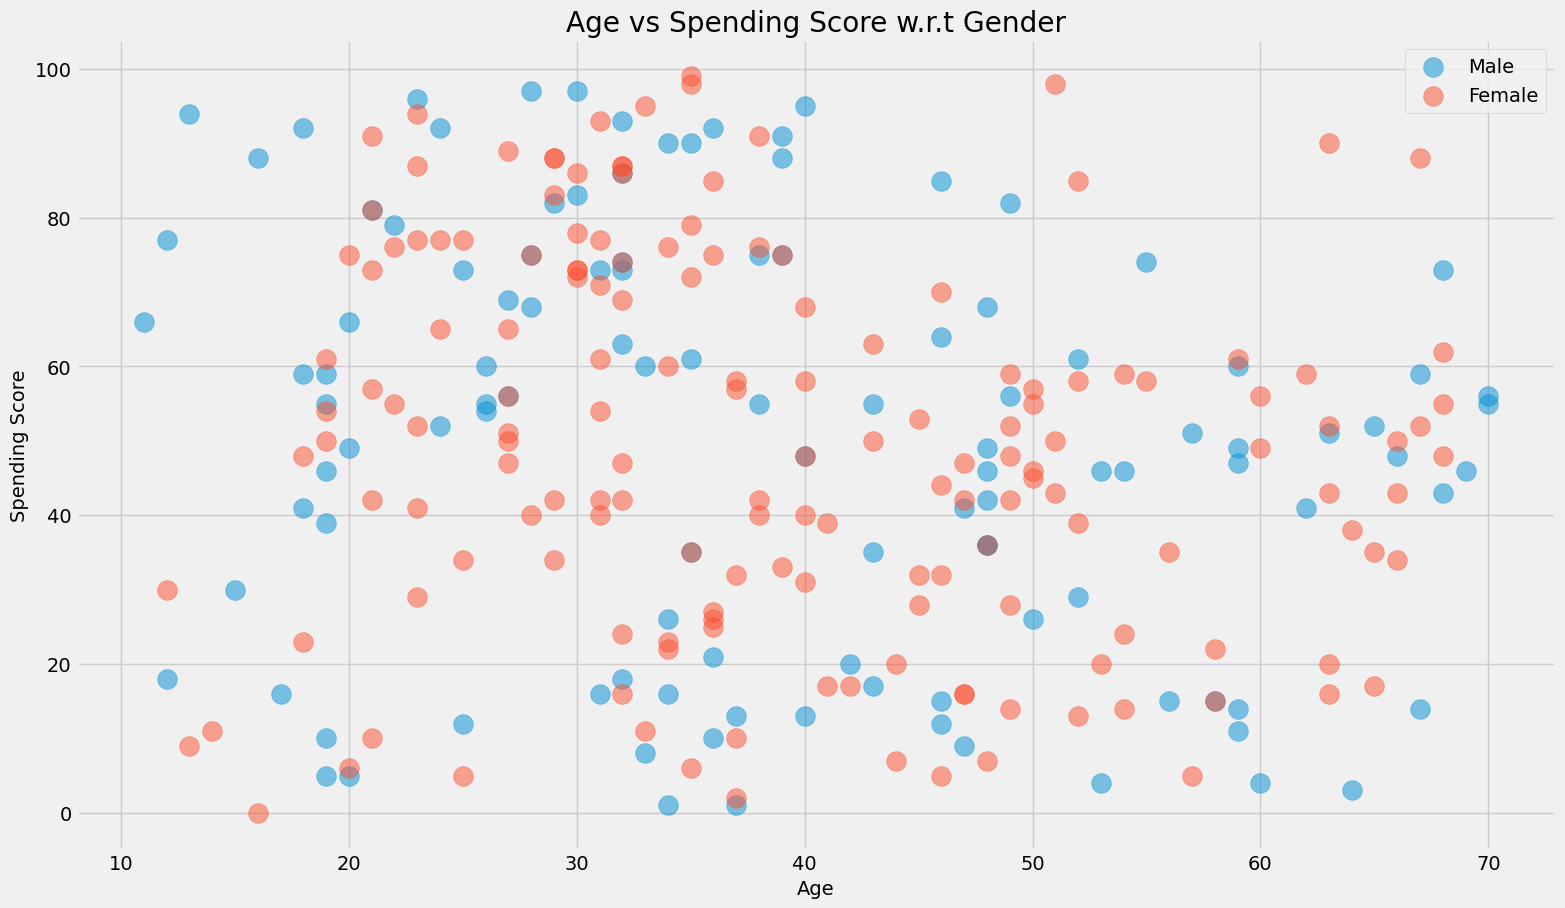

In [179]:
plt.figure(1 , figsize = (17 , 10))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age',y = 'Spending Score' ,
                data = shop[(shop['Gender'] == gender)] 
                ,s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Age'), plt.ylabel('Spending Score') 
plt.title('Age vs Spending Score w.r.t Gender')
plt.legend(loc='upper right')
plt.show()

### <font color='Blue'>График рассеивания атрибутов <font color='red'>Age</font> и <font color='red'>Spending Score </font> относительно <font color='red'> Profession</font></font>

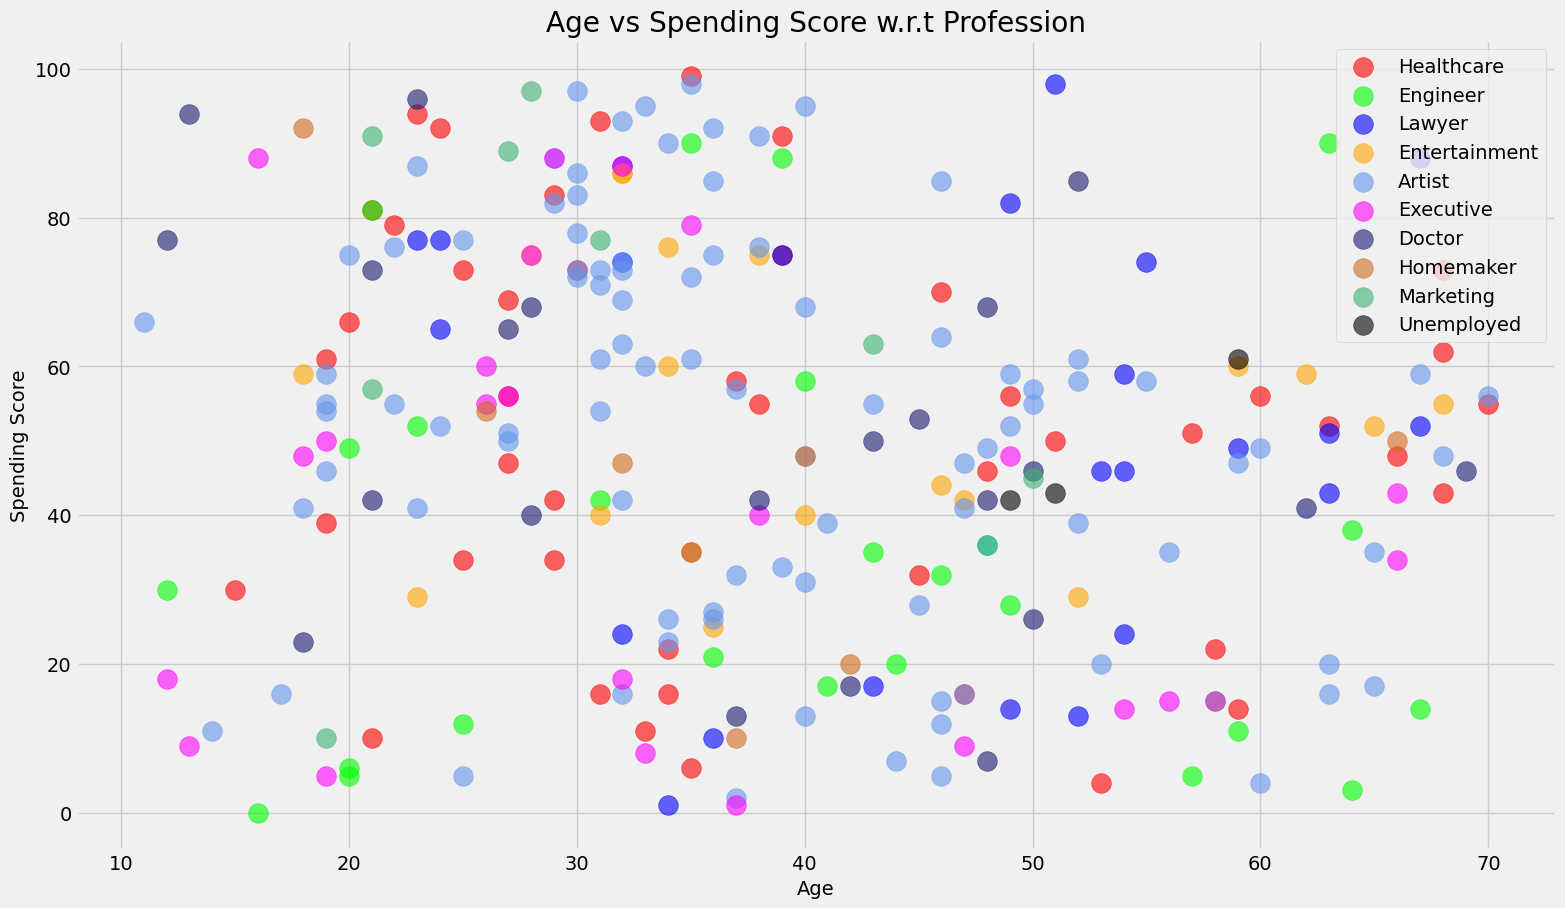

In [180]:
plt.figure(1 , figsize = (17 , 10))
row=['#FF0000', '#00FF00', '#0000FF', '#FFA500', '#6495ED', '#FF00FF', '#191970', '#D2691E','#3CB371','#000000']
i=0
for profession in ['Healthcare' , 'Engineer', 'Lawyer', 'Entertainment','Artist', 'Executive', 'Doctor', 'Homemaker','Marketing', 'Unemployed']:
    plt.scatter(x = 'Age',y = 'Spending Score' ,
                data = shop[(shop['Profession'] == profession)] 
                ,s = 200 , alpha = 0.6 , label = profession, c=row[i])
    i+=1
plt.xlabel('Age'), plt.ylabel('Spending Score') 
plt.title('Age vs Spending Score w.r.t Profession')
plt.legend()
plt.show()

### <font color='Blue'>График рассеивания атрибутов <font color='red'>Annual Income(K$)</font> и <font color='red'>Spending Score </font> относительно <font color='red'> Gender</font></font>

**На даном графике можно выделить примерно 7-9 групп.**

Так же основываясь на уровне годового дохода(низкий, средний, высокий) и оценки количества покупок (низкая, средняя, высокая).

Например: Группа с низким доходом и низкой оценкой колличества покупок и тд.

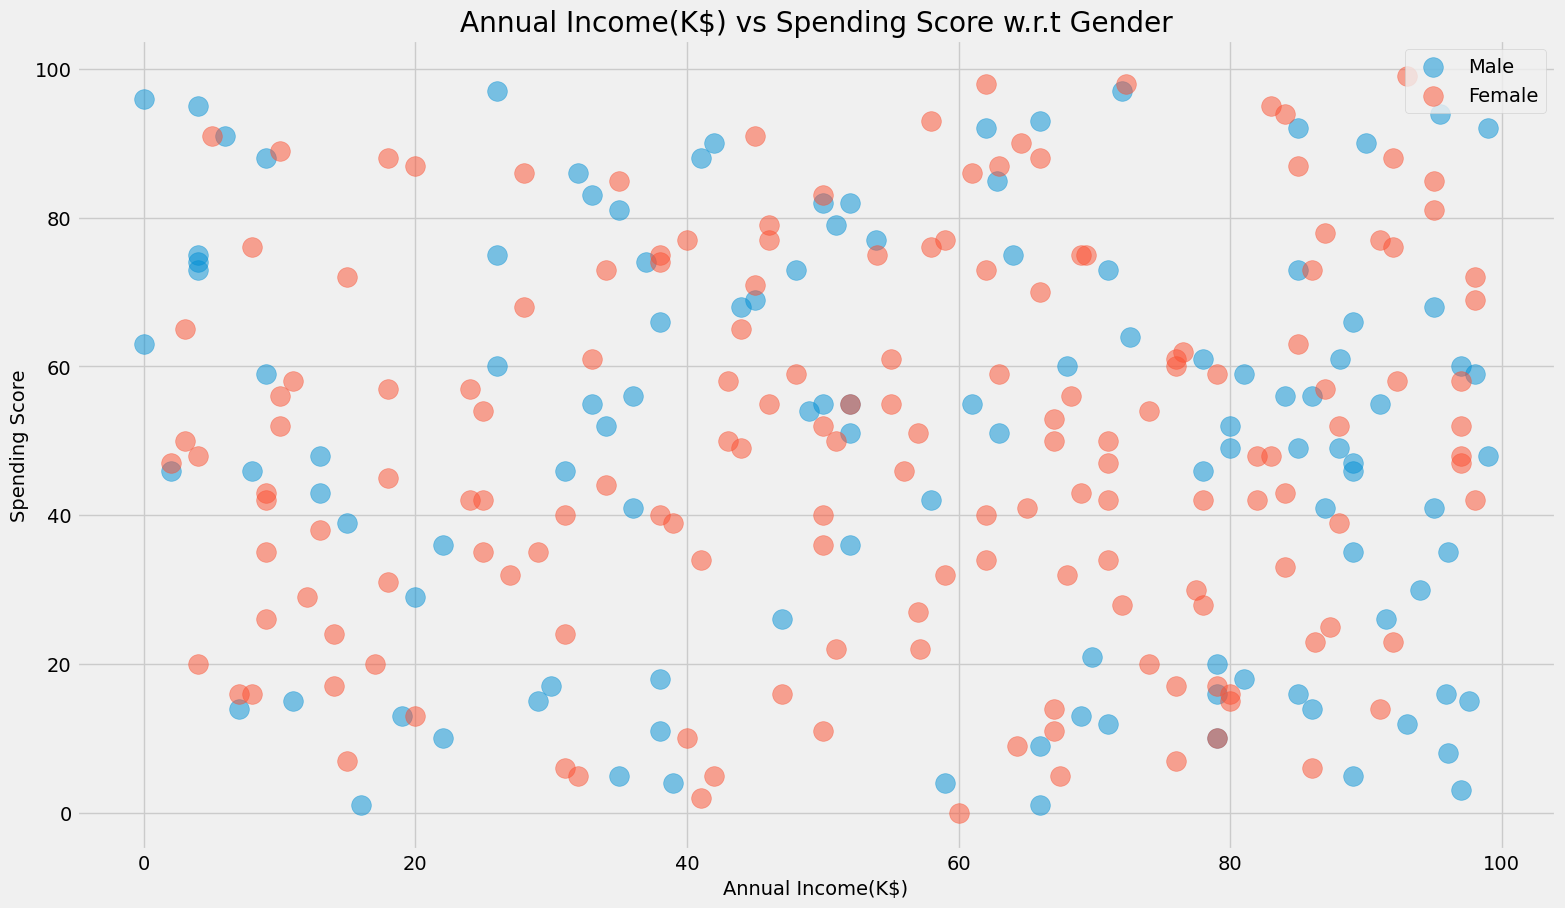

In [181]:
plt.figure(1 , figsize = (17 , 10))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income(K$)',y = 'Spending Score' ,
                data = shop[(shop['Gender'] == gender)] 
                ,s = 200 , alpha = 0.5 , label = gender)
plt.xlabel('Annual Income(K$)'), plt.ylabel('Spending Score') 
plt.title('Annual Income(K$) vs Spending Score w.r.t Gender')
plt.legend(loc='upper right')
plt.show()

### <font color='Blue'>График рассеивания атрибутов <font color='red'>Annual Income(K$)</font> и <font color='red'>Spending Score </font> относительно <font color='red'> Profession</font></font>

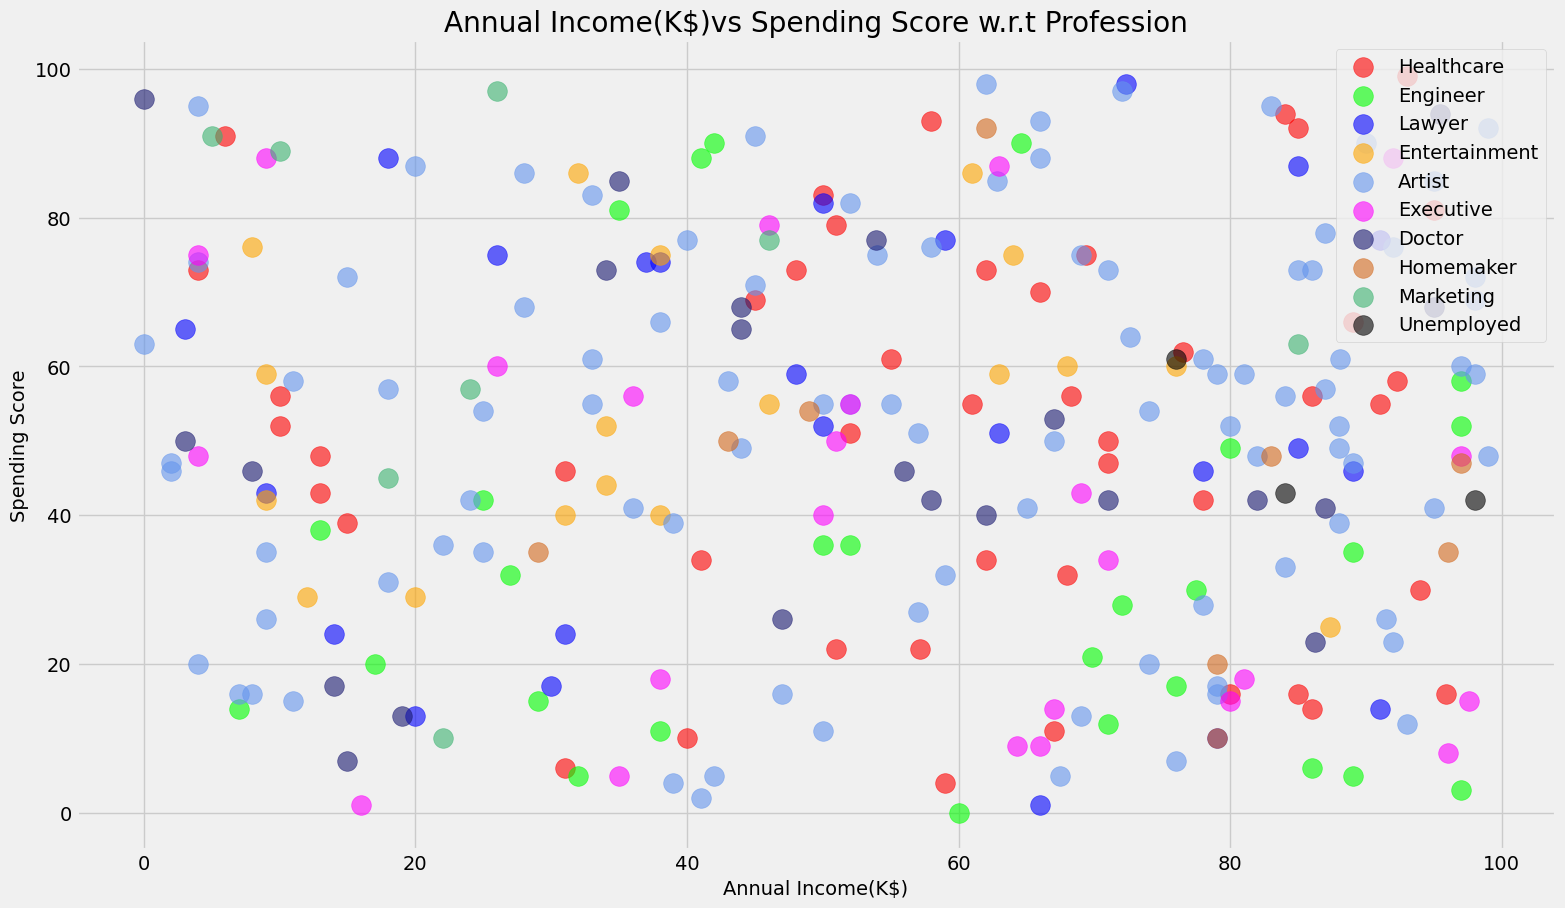

In [182]:
plt.figure(1 , figsize = (17 , 10))
row=['#FF0000', '#00FF00', '#0000FF', '#FFA500', '#6495ED', '#FF00FF', '#191970', '#D2691E','#3CB371','#000000']
i=0
for profession in ['Healthcare' , 'Engineer', 'Lawyer', 'Entertainment','Artist', 'Executive', 'Doctor', 'Homemaker','Marketing', 'Unemployed']:
    plt.scatter(x = 'Annual Income(K$)',y = 'Spending Score' ,
                data = shop[(shop['Profession'] == profession)] 
                ,s = 200 , alpha = 0.6 , label = profession, c=row[i])
    i+=1
plt.xlabel('Annual Income(K$)'), plt.ylabel('Spending Score') 
plt.title('Annual Income(K$)vs Spending Score w.r.t Profession')
plt.legend(loc='upper right')
plt.show()

# 3. Кластеризация (K-mean)

### <font color='Blue'> Выделение кластеров между <font color='red'>Age</font> и <font color='red'>Annual Income(K$) </font>  </font>

In [183]:
X1 = shop[['Age' , 'Annual Income(K$)']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

F:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.

F:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



### <font color='Blue'>График инерции</font>

**Чем меньше значение инерции тем более связные кластеры. На основе значения инерции выбираем колличество кластеров**

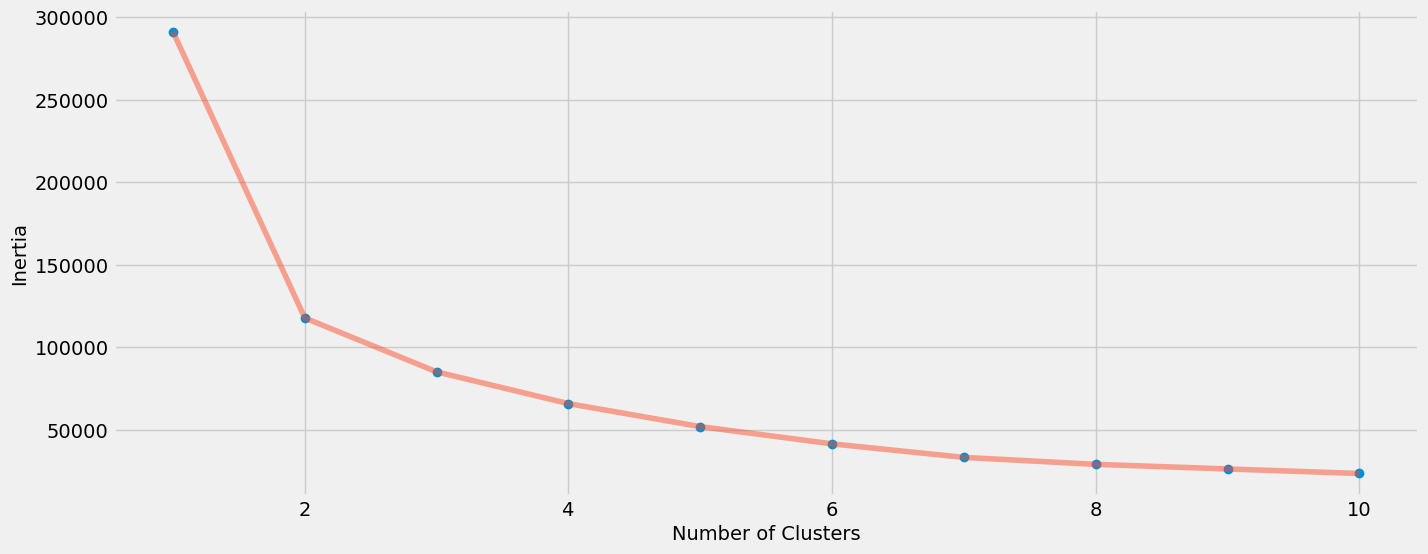

In [184]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

### <font color='Blue'> Расчёт центров для 6 кластеров </font>

In [185]:
algorithm = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [186]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

### <font color='Blue'>График кластеризации</font>

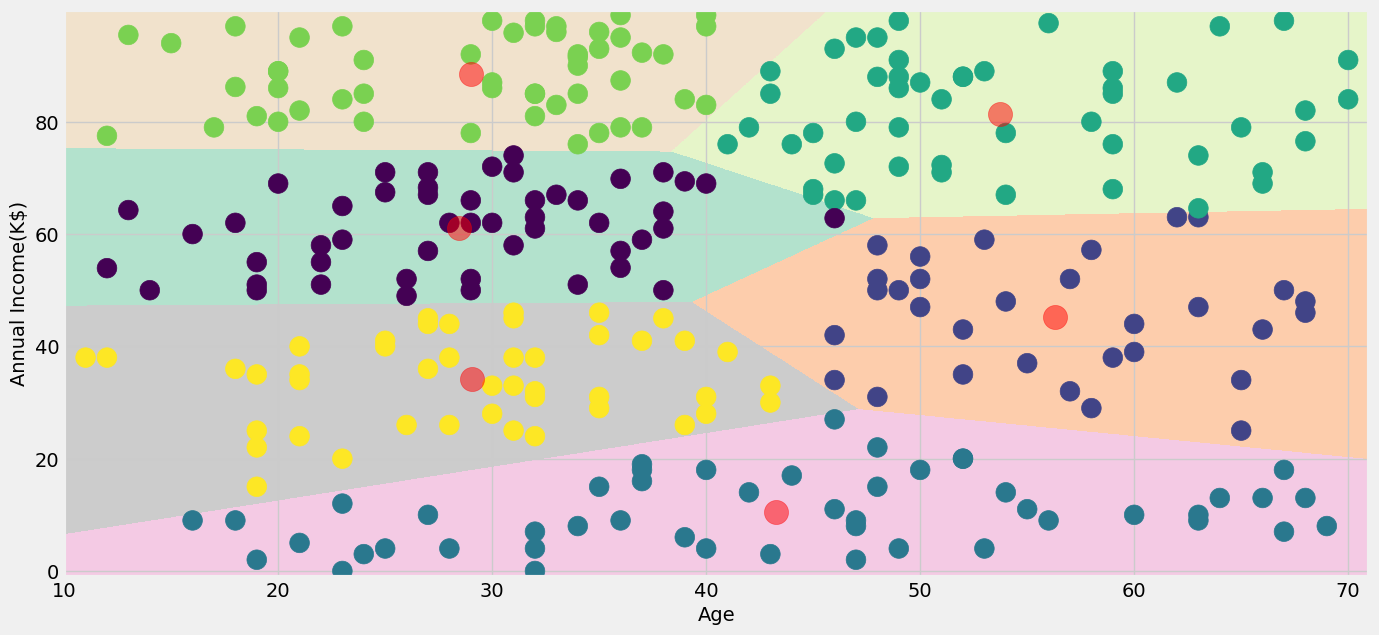

In [187]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Annual Income(K$)' , data = shop , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Annual Income(K$)') , plt.xlabel('Age')
plt.show()


### <font color='Blue'> Выделение кластеров между <font color='red'>Age</font> и <font color='red'>Spending Score </font>  </font>

In [188]:
X2 = shop[['Age' , 'Spending Score']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

F:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.

F:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



### <font color='Blue'>График инерции</font>

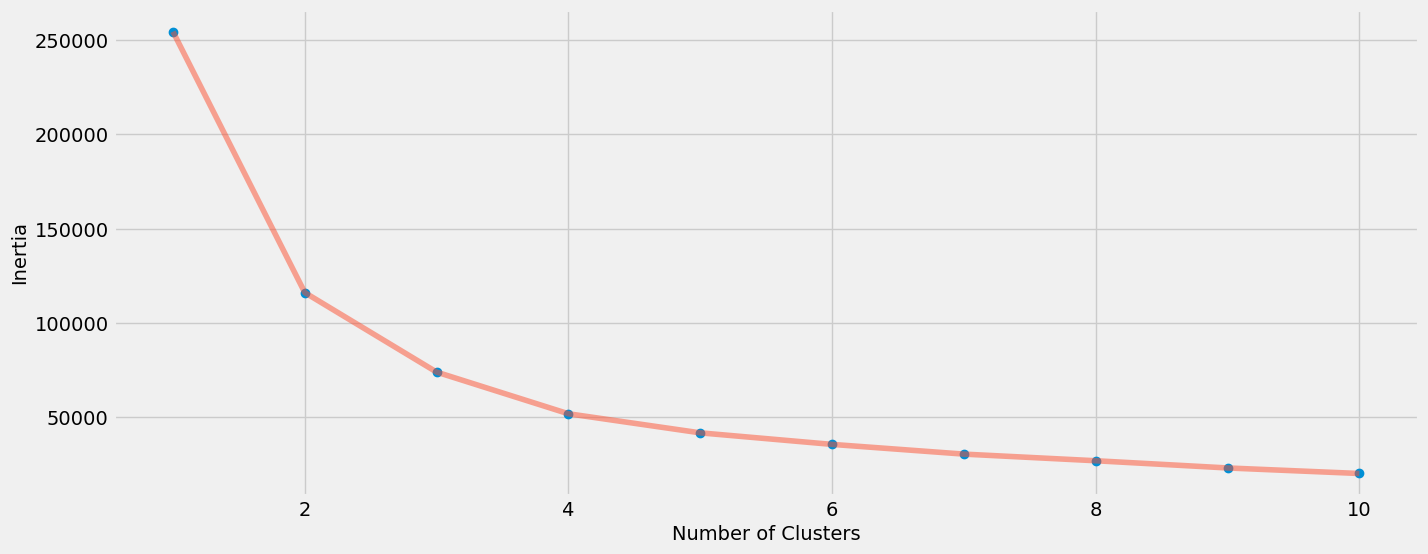

In [189]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [190]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [191]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

### <font color='Blue'>График кластеризации</font>

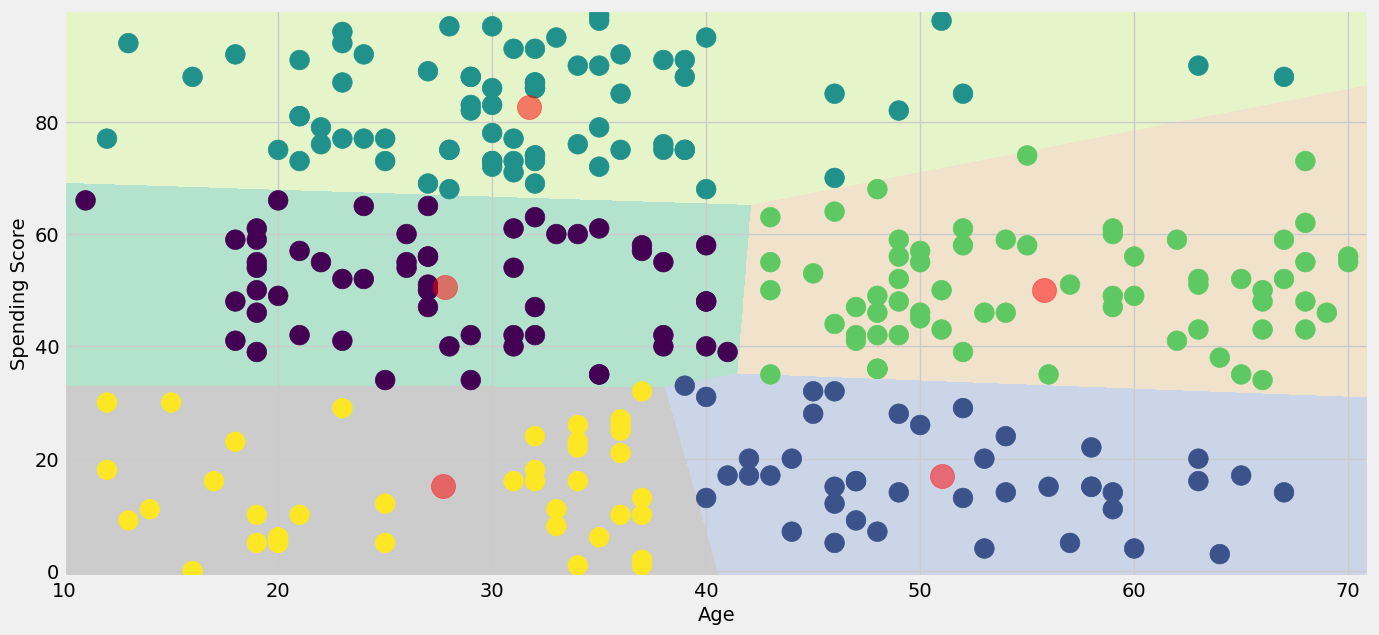

In [192]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score' , data = shop , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score') , plt.xlabel('Age')
plt.show()


### <font color='Blue'> Выделение кластеров между <font color='red'>Annual Income(K$)</font> и <font color='red'>Spending Score </font>  </font>

In [193]:
X3 = shop[['Annual Income(K$)' , 'Spending Score']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

F:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.

F:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



### <font color='Blue'>График инерции</font>

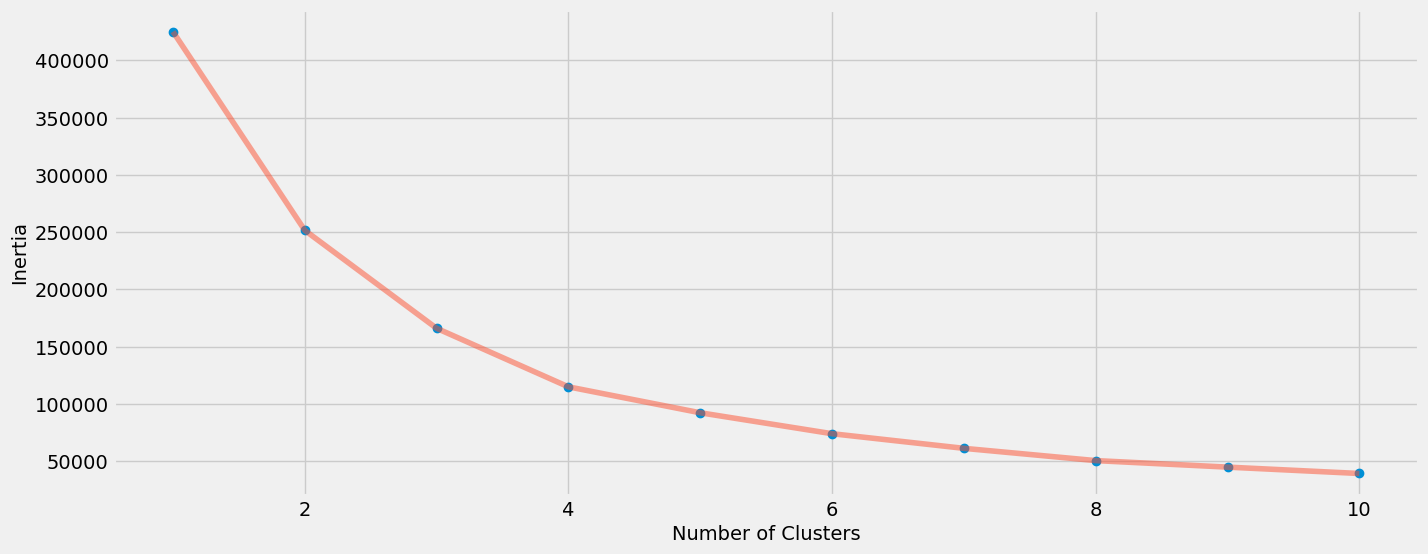

In [194]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [195]:
algorithm = (KMeans(n_clusters = 7 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

In [196]:
h = 0.02
x_min, x_max = X3[:, 0].min() - 1, X3[:, 0].max() + 1
y_min, y_max = X3[:, 1].min() - 1, X3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

### <font color='Blue'>График кластеризации</font>

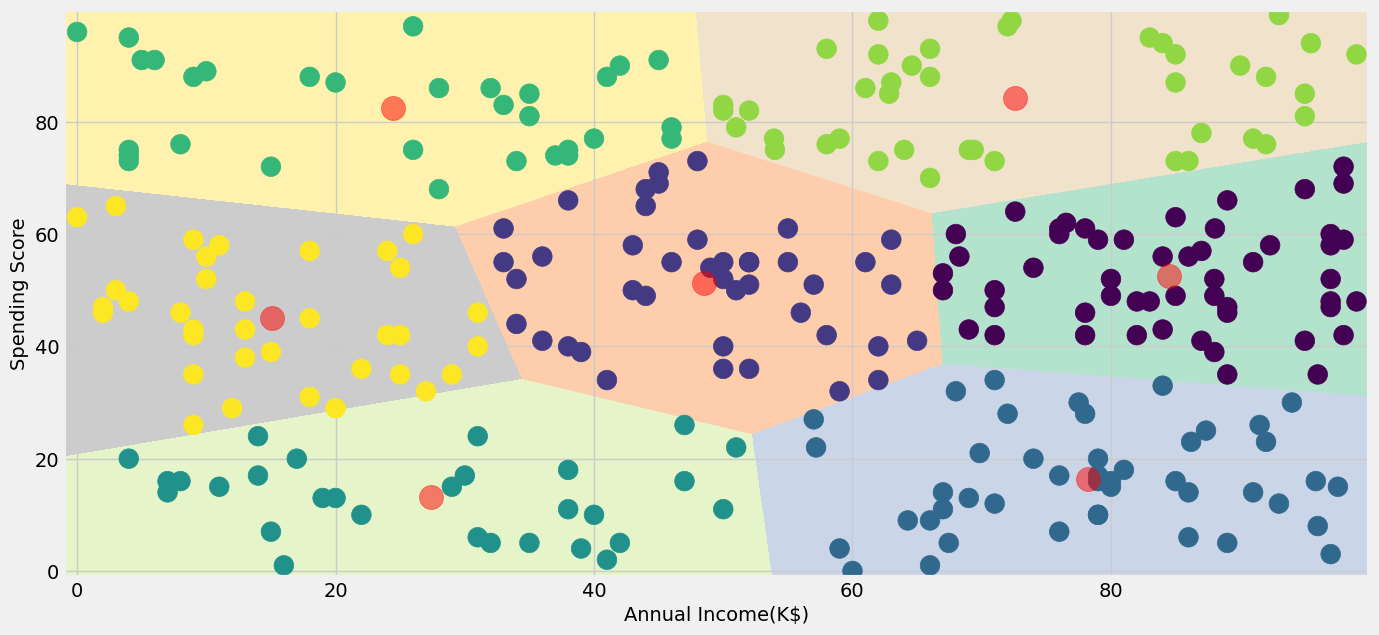

In [197]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Annual Income(K$)' ,y = 'Spending Score' , data = shop , c = labels3 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score') , plt.xlabel('Annual Income(K$)')
plt.show()

### <font color='Blue'>Попробуем связать все 3 атрибута (<font color='red'>Annual Income(K$)</font>,<font color='red'>Spending Score </font>,<font color='red'>Age</font>)</font>

In [198]:
X4 = shop[['Age' , 'Annual Income(K$)' ,'Spending Score']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X4)
    inertia.append(algorithm.inertia_)

F:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.

F:\Programs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



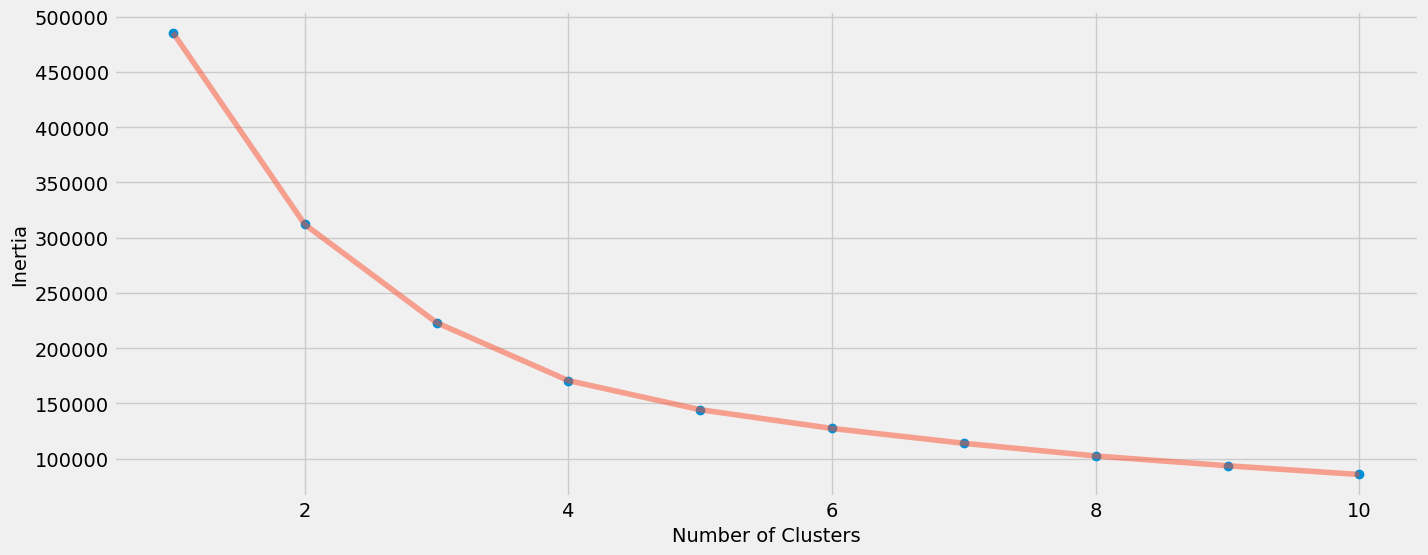

In [199]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [200]:
algorithm = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X4)
labels4 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

In [203]:
shop['label4'] =  labels4
trace1 = go.Scatter3d(
    x= shop['Age'],
    y= shop['Spending Score'],
    z= shop['Annual Income(K$)'],
    mode='markers',
     marker=dict(
        color = shop['label4'], 
        size= 20,
        line=dict(
            color= shop['label4'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(

    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

### <font align='justify'>Смотря на этот график, можно сделать вывод, что возраст особо не влияет на группы между <font color='red'>Annual Income(K$)</font> и <font color='red'>Spending Score </font>. То есть в каждой группе точки примерно одинаково распределяются по оси возраста. Так происходит скорее всего из за не очень дастоверных данных в датасете.</font>